In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from deepxde.backend import tf
%matplotlib inline

import deepxde as dde

Using backend: tensorflow.compat.v1

2022-12-01 09:24:29.439628: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



2022-12-01 09:24:32.029586: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-01 09:24:32.030836: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-01 09:24:32.120383: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:64:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-12-01 09:24:32.120426: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-12-01 09:24:32.122879: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-01 09:24:32.122934: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [78]:
import seaborn as sns
sns.set_context("talk")

In [2]:
dde.config.set_default_float("float64")
#dde.config.real.set_float64()
dde.config.set_random_seed(123456789)

x_max = 1e-3
y_max = 0.23e-3
z_max = 0.1e-3
P_min = 100
P_max = 300

geo = dde.geometry.Hypercube((0.0, 0.0, 0.0, P_min), (x_max, y_max, z_max, P_max))

Set the default float type to float64


In [3]:
t_max = 0.002

time = dde.geometry.TimeDomain(0, t_max)
domain = dde.geometry.GeometryXTime(geo, time)

In [4]:
A = 0.09
D = 140e-6
R = D/2
v = 200e-3
T_0 = 273.15

In [5]:
def pde_system(X, output):
    
    T = output
    
    dT_dx = dde.grad.jacobian(T, X, j = 0)
    dT_dy = dde.grad.jacobian(T, X, j = 1)
    dT_dz = dde.grad.jacobian(T, X, j = 2)
    dT_dt = dde.grad.jacobian(T, X, j = 4)
       
    k = (11.82+1.06e-2*T)
    c = (330.9+0.563*T-4.015e-4*T**2+9.465e-8*T**3)
    rho = 7800.0*T**0
    
    k_eff = 0.6*k
    rho_eff = 0.6*rho
    
    diff_T = dde.grad.jacobian(k_eff*dT_dx, X, j = 0) + dde.grad.jacobian(k_eff*dT_dy, X, j=1) + dde.grad.jacobian(k_eff*dT_dz, X, j = 2)
    
    f_T = dT_dt - diff_T/(rho_eff*c)# + 272e3/(c**2*rho)*tf.cast(molten, 'float64')
        
    return f_T

def dummy(X, output):
    return output

In [6]:
def top_bc(X, Y):
    
    r_sq = (X[:,0:1] - x_max/4 - X[:,4:5]*v)**2 + (X[:,1:2] - y_max/2)**2
    k = (11.82+1.06e-2*Y)
    k_eff = 0.6*k
    return 2*A*X[:,3:4]/(np.pi*R**2)*tf.exp(-2*r_sq/R**2)/k_eff

ic = dde.icbc.IC(domain, lambda on_initial: 20.0 + T_0, lambda x, on_initial: on_initial and not np.isclose(x[2], z_max, atol=z_max/20))
top = dde.icbc.RobinBC(domain, lambda X, Y : top_bc(X, Y), lambda x, on_boundary: np.isclose(x[2], z_max, atol=z_max/40))
sides = dde.icbc.DirichletBC(domain, lambda X : 20.0 + T_0, lambda x, on_boundary: on_boundary and not np.isclose(x[2], z_max, atol=z_max/40))

In [7]:
geo_bound = dde.geometry.Hypercube((0.05*x_max, 0.1*y_max, P_min), (0.95*x_max, 0.9*y_max, P_max))
domain_bound = dde.geometry.GeometryXTime(geo_bound, time)
x_bound, y_bound, P_bound, t_bound = domain_bound.random_points(100000, random='Hammersley').T

input_bound = np.vstack((x_bound, y_bound, np.ones(len(x_bound))*z_max, P_bound, t_bound)).T

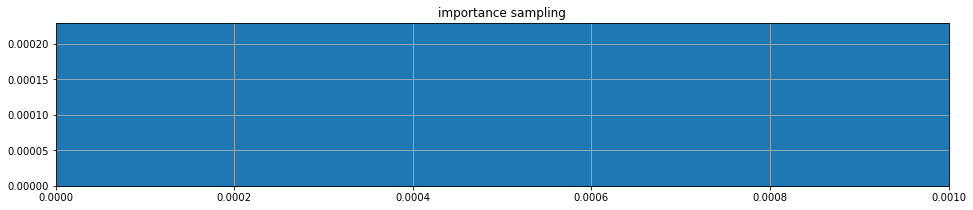

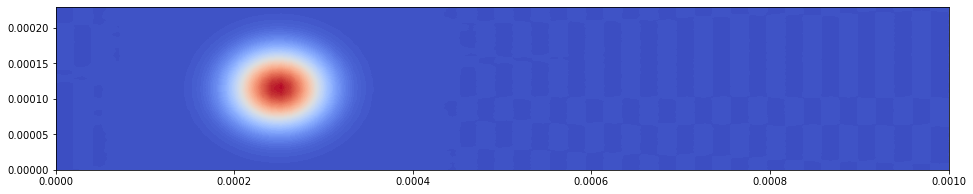

In [8]:
data = dde.data.TimePDE(domain,
                       pde_system,
                       ic_bcs = [top],
                       num_domain = 100000,
                       num_initial = 0,
                       num_boundary = 0,
                       train_distribution="Hammersley",
                       anchors=input_bound)

points = data.train_points().T
    
plt.figure(figsize = (16, 3))
plt.scatter(points[0], points[1], marker = '.')
plt.xlim([0, x_max])
plt.ylim([0, y_max])
#plt.colorbar()
plt.title('importance sampling')
plt.grid()
plt.show()
def top_bc_test(X):
    
    r_sq = (X[:,0:1] - x_max/4 - X[:,3:4]*v)**2 + (X[:,1:2] - y_max/2)**2
    return 2*A*P_max/(np.pi*R**2)*np.exp(-2*r_sq/R**2)

x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [0])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T
xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
plot_data = griddata((np.ravel(xx), np.ravel(yy)), top_bc_test(X)[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (16, 3))
plt.contourf(xi, yi, plot_data, 100, cmap=plt.cm.coolwarm)
#plt.colorbar()

In [19]:
def d_z(X, output):
    
    T = output
    dT_dz = dde.grad.jacobian(T, X, j = 2)
        
    return dT_dz

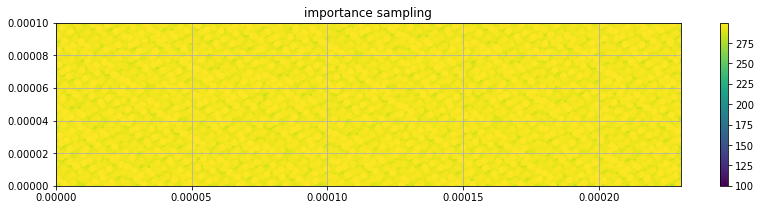

In [9]:
plt.figure(figsize = (14, 3))
plt.scatter(points[1], points[2], c = points[3], marker = 'o')
plt.xlim([0, y_max])
plt.ylim([0, z_max])
plt.colorbar()
plt.title('importance sampling')
plt.grid()

In [10]:
points.shape

(5, 200000)

In [11]:
#activation = f"LAAF-{5} sin"
net = dde.nn.FNN([5] + [40] * 6 + [1], "sin", "Glorot normal")
 
#net = dde.nn.MsFFN([4] + [20] * 6 + [1], 'sin', "Glorot normal", sigmas = [1, 0.1])
#net = dde.nn.ResNet(input_size=4, output_size=1, num_neurons=20, num_blocks=3, activation='sin', kernel_initializer="Glorot normal")

def feature_transform(X):
    return tf.concat(
        [(X[:, 0:1]/x_max - 0.5), 
         (X[:, 1:2]/y_max - 0.5),
         (X[:, 2:3]/z_max - 0.5),
         (X[:, 3:4]/(P_max-P_min) - 0.5),
         (X[:, 4:5]/t_max - 0.5)], axis=1
    )
net.apply_feature_transform(feature_transform)

def modify_output(X, Y):
    x, y, z, p, t = X[:, 0:1], X[:, 1:2], X[:, 2:3], X[:, 3:4], X[:, 4:5]
    Temperature = Y
    #T_new = 20.0 + T_0 + Temperature*4000e22*x*y*(x-x_max)*(y-y_max)*t*z
    T_new = 20.0 + T_0 - Temperature*5e23*x*y*(x-x_max)*(y-y_max)*t*z*p
    return tf.concat(T_new, axis = 1)
net.apply_output_transform(modify_output)

model = dde.Model(data, net)
model.compile("adam", lr=1e-5)
losshistory, train_state = model.train(epochs=0, display_every=1000)
weights = 1/np.array(losshistory.loss_train[0])

Compiling model...
Building feed-forward neural network...
'build' took 0.131640 s



/home/sc.uni-leipzig.de/nl220wxeo/.conda/envs/dde/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/sc.uni-leipzig.de/nl220wxeo/.conda/envs/dde/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2022-12-01 09:24:51.232107: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 09:

'compile' took 10.936220 s

Initializing variables...


2022-12-01 09:25:02.268125: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2022-12-01 09:25:02.562372: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000074999 Hz


Training model...



2022-12-01 09:25:03.884281: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x14daf800c740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-01 09:25:03.884340: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2022-12-01 09:25:04.590035: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-01 09:25:07.921422: I tensorflow/compiler/jit/xla_compilation_cache.cc:333] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss              Test loss               Test metric
0         [1.29e+17, 3.51e+21]    [1.29e+17, 3.51e+21]    []  

Best model at step 0:
  train loss: 3.52e+21
  test loss: 3.52e+21
  test metric: []

'train' took 9.699951 s



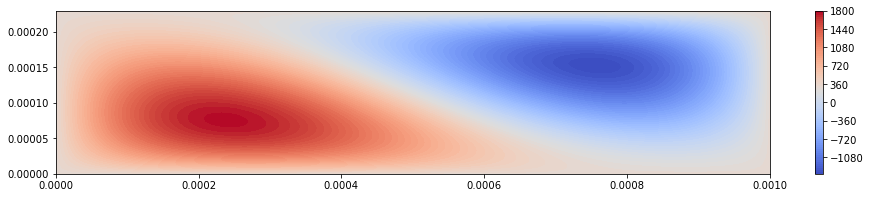

In [12]:
from scipy.interpolate import griddata

x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)
xx, yy, zz, pp, tt = np.meshgrid(x_lin, y_lin, [z_max], [100], [t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(pp), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
predict = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (16, 3))
plt.contourf(xi, yi, predict, 100, cmap=plt.cm.coolwarm)
plt.colorbar()

In [13]:
weights_2 = np.array([1, 1e2])
dde.optimizers.config.set_LBFGS_options(maxcor=100, maxiter=5000, maxls=50)
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(display_every=100)

Compiling model...
'compile' took 10.289888 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [2.14e+01, 2.36e+02]    [2.14e+01, 2.36e+02]    []  
100       [1.05e-01, 4.85e-02]                                
200       [6.95e-02, 5.24e-02]                                
300       [5.46e-02, 3.99e-02]                                
400       [5.12e-02, 3.16e-02]                                
500       [4.53e-02, 2.56e-02]                                
600       [4.31e-02, 2.38e-02]                                
700       [4.20e-02, 2.17e-02]                                
800       [4.18e-02, 1.98e-02]                                
900       [4.16e-02, 1.90e-02]                                
1000      [4.17e-02, 1.85e-02]                                
1100      [4.13e-02, 1.83e-02]                                
1200      [4.13e-02, 1.79e-02]                                
1300      [4.12e-02

In [26]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, maxiter=10000, maxls=50)
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(display_every=100)

Compiling model...
'compile' took 11.431081 s



2022-12-01 09:50:02.391721: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1642] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.


Training model...

Step      Train loss              Test loss               Test metric
5715      [3.67e-02, 1.51e-02]    [3.67e-02, 1.51e-02]    []  
5800      [1.81e-03, 1.78e-04]                                
5900      [1.24e-03, 1.25e-04]                                
6000      [7.05e-04, 8.95e-05]                                
6100      [3.26e-04, 6.03e-05]                                
6200      [2.15e-04, 4.98e-05]                                
6300      [1.75e-04, 4.17e-05]                                
6400      [1.30e-04, 4.25e-05]                                
6500      [1.14e-04, 4.04e-05]                                
6600      [1.04e-04, 3.69e-05]                                
6700      [9.40e-05, 3.41e-05]                                
6800      [8.98e-05, 3.17e-05]                                
6900      [8.75e-05, 3.19e-05]                                
7000      [9.05e-05, 3.36e-05]                                
7100      [7.08e-05, 3.23e-05

In [18]:
points = domain.random_points(100000, random='Hammersley')
errs = np.abs(model.predict(points, operator=pde_system))
points_error = points[errs.T[0].argsort()[-10000:]]

In [20]:
x_bound, y_bound, p_bound, t_bound = domain_bound.random_points(100000, random='Hammersley').T
input_bound = np.vstack((x_bound, y_bound, np.ones(len(x_bound))*z_max, p_bound, t_bound)).T

dz_pred = model.predict(points, operator=d_z)
dz_cond = model.predict(points, operator=top_bc)

errs_bound = np.abs(dz_cond - dz_pred).T[0]
points_error_bound = points[errs_bound.argsort()[-10000:]]

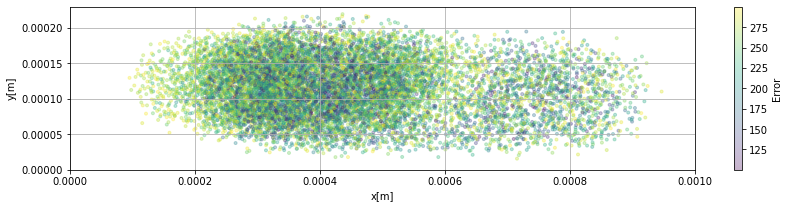

In [24]:
plt.figure(figsize = (14, 3))
plt.scatter(points_error_bound.T[0], points_error_bound.T[1], c = points_error_bound.T[3], marker = '.', alpha=0.3)
plt.xlim([0, x_max])
plt.ylim([0, y_max])
plt.colorbar(label='Error')
plt.xlabel('x[m]')
plt.ylabel('y[m]')
plt.grid()

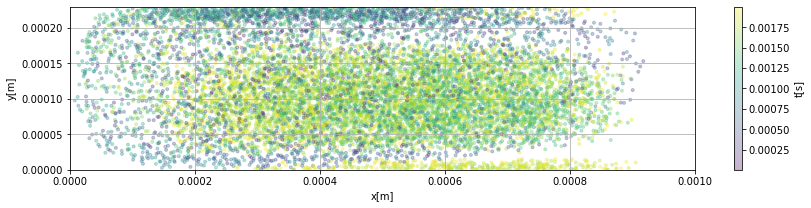

In [25]:
plt.figure(figsize = (14, 3))
plt.scatter(points_error.T[0], points_error.T[1], c = points_error.T[4], marker = '.', alpha=0.3)
plt.xlim([0, x_max])
plt.ylim([0, y_max])
plt.colorbar(label='t[s]')
plt.xlabel('x[m]')
plt.ylabel('y[m]')
plt.grid()

In [31]:
data.add_anchors(points_error)
data.add_anchors(points_error_bound)

In [32]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, maxiter=10000, maxls=50)
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(display_every=100)

Compiling model...
'compile' took 12.821474 s

Training model...

Step      Train loss              Test loss               Test metric
10222     [1.53e-05, 3.54e-05]    [1.56e-05, 3.54e-05]    []  
10300     [1.54e-05, 3.51e-05]                                
10400     [1.32e-05, 3.44e-05]                                
10500     [1.17e-05, 3.35e-05]                                
10600     [1.11e-05, 3.26e-05]                                
10700     [1.63e-01, 9.80e-05]                                
10800     [8.31e-06, 3.19e-05]                                
10900     [7.98e-06, 3.08e-05]                                
11000     [7.34e-06, 3.08e-05]                                
11100     [7.35e-06, 3.01e-05]                                
11200     [6.96e-06, 3.02e-05]                                
11300     [6.37e-06, 2.99e-05]                                
11400     [6.46e-06, 2.97e-05]                                
11500     [6.68e-06, 2.89e-05]               

In [40]:
points = domain.random_points(100000, random='Hammersley')
errs = np.abs(model.predict(points, operator=pde_system))
points_error = points[errs.T[0].argsort()[-10000:]]

x_bound, y_bound, p_bound, t_bound = domain_bound.random_points(100000, random='Hammersley').T
input_bound = np.vstack((x_bound, y_bound, np.ones(len(x_bound))*z_max, p_bound, t_bound)).T

dz_pred = model.predict(points, operator=d_z)
dz_cond = model.predict(points, operator=top_bc)

errs_bound = np.abs(dz_cond - dz_pred).T[0]
points_error_bound = points[errs_bound.argsort()[-10000:]]

data.add_anchors(points_error)
data.add_anchors(points_error_bound)

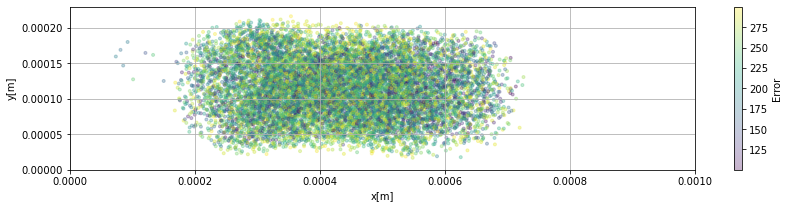

In [41]:
plt.figure(figsize = (14, 3))
plt.scatter(points_error_bound.T[0], points_error_bound.T[1], c = points_error_bound.T[3], marker = '.', alpha=0.3)
plt.xlim([0, x_max])
plt.ylim([0, y_max])
plt.colorbar(label='Error')
plt.xlabel('x[m]')
plt.ylabel('y[m]')
plt.grid()

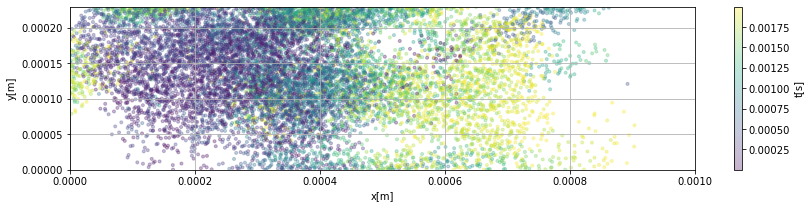

In [42]:
plt.figure(figsize = (14, 3))
plt.scatter(points_error.T[0], points_error.T[1], c = points_error.T[4], marker = '.', alpha=0.3)
plt.xlim([0, x_max])
plt.ylim([0, y_max])
plt.colorbar(label='t[s]')
plt.xlabel('x[m]')
plt.ylabel('y[m]')
plt.grid()

In [43]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, maxiter=10000, maxls=50)
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(display_every=100)

Compiling model...
'compile' took 14.476177 s

Training model...

Step      Train loss              Test loss               Test metric
22723     [5.75e-06, 4.50e-06]    [3.06e-06, 4.50e-06]    []  
22800     [3.30e-06, 4.79e-06]                                
22900     [2.91e-06, 4.78e-06]                                
23000     [2.77e-06, 4.56e-06]                                
23100     [2.70e-06, 4.35e-06]                                
23200     [2.54e-06, 4.23e-06]                                
23300     [2.44e-06, 3.99e-06]                                
23400     [2.45e-06, 3.73e-06]                                
23500     [2.38e-06, 3.48e-06]                                
23600     [2.31e-06, 3.28e-06]                                
23700     [2.22e-06, 3.13e-06]                                
23800     [2.11e-06, 3.04e-06]                                
23900     [2.06e-06, 2.91e-06]                                
24000     [2.02e-06, 2.85e-06]               

In [50]:
points = domain.random_points(100000, random='Hammersley')
errs = np.abs(model.predict(points, operator=pde_system))
points_error = points[errs.T[0].argsort()[-10000:]]

x_bound, y_bound, p_bound, t_bound = domain_bound.random_points(100000, random='Hammersley').T
input_bound = np.vstack((x_bound, y_bound, np.ones(len(x_bound))*z_max, p_bound, t_bound)).T

dz_pred = model.predict(points, operator=d_z)
dz_cond = model.predict(points, operator=top_bc)

errs_bound = np.abs(dz_cond - dz_pred).T[0]
points_error_bound = points[errs_bound.argsort()[-10000:]]

data.add_anchors(points_error)
data.add_anchors(points_error_bound)

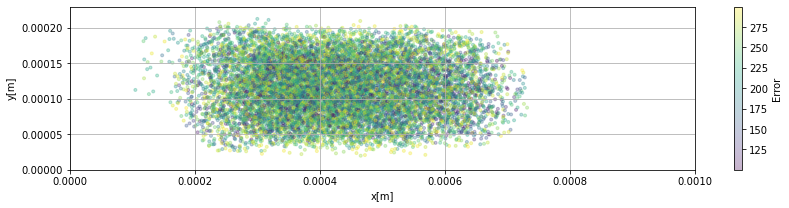

In [51]:
plt.figure(figsize = (14, 3))
plt.scatter(points_error_bound.T[0], points_error_bound.T[1], c = points_error_bound.T[3], marker = '.', alpha=0.3)
plt.xlim([0, x_max])
plt.ylim([0, y_max])
plt.colorbar(label='Error')
plt.xlabel('x[m]')
plt.ylabel('y[m]')
plt.grid()

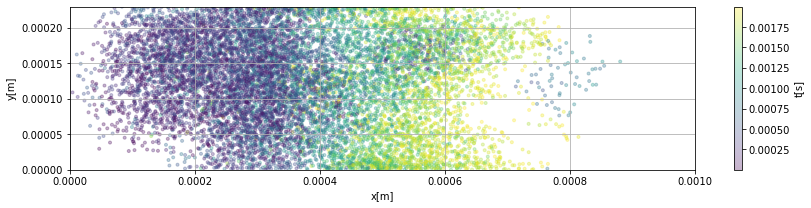

In [52]:
plt.figure(figsize = (14, 3))
plt.scatter(points_error.T[0], points_error.T[1], c = points_error.T[4], marker = '.', alpha=0.3)
plt.xlim([0, x_max])
plt.ylim([0, y_max])
plt.colorbar(label='t[s]')
plt.xlabel('x[m]')
plt.ylabel('y[m]')
plt.grid()

In [53]:
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(display_every=100)

Compiling model...
'compile' took 15.128916 s

Training model...

Step      Train loss              Test loss               Test metric
30690     [9.17e-07, 1.23e-06]    [5.22e-07, 1.23e-06]    []  
30700     [9.09e-07, 1.23e-06]                                
30800     [8.28e-07, 1.27e-06]                                
30900     [7.97e-07, 1.28e-06]                                
31000     [7.80e-07, 1.28e-06]                                
31100     [7.68e-07, 1.27e-06]                                
31200     [7.51e-07, 1.26e-06]                                
31300     [7.40e-07, 1.26e-06]                                
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000002
  Number of iterations: 525
  Number of functions evaluations: 690
31380     [7.35e-07, 1.26e-06]    [4.71e-07, 1.26e-06]    []  

Best model at step 30690:
  train loss: 1.95e-06
  test loss: 1.76e-06
  test metric: [

In [1]:
1051.359525 + 834.412331 + 2395.566730 + 1623.754743 + 180.392660

6085.485989

In [63]:
model.save('laser_power')

INFO:tensorflow:laser_power-31380.ckpt is not in all_model_checkpoint_paths. Manually adding it.


'laser_power-31380.ckpt'

In [65]:
np.save('power_losses/test_loss.npy', losshistory.loss_test)
np.save('power_losses/train_loss.npy', losshistory.loss_train)

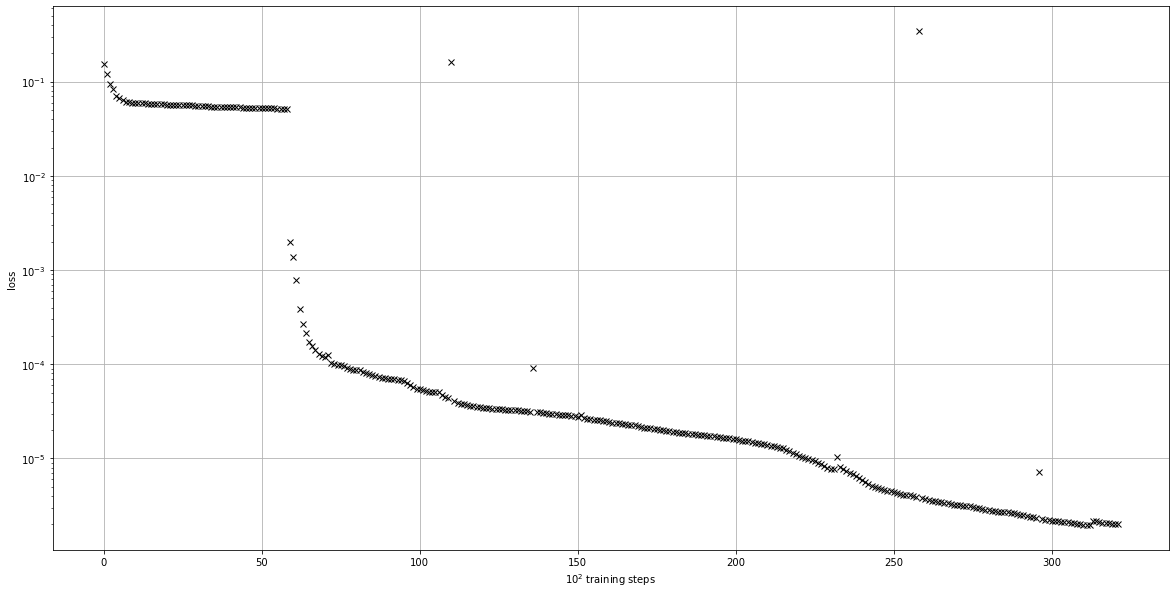

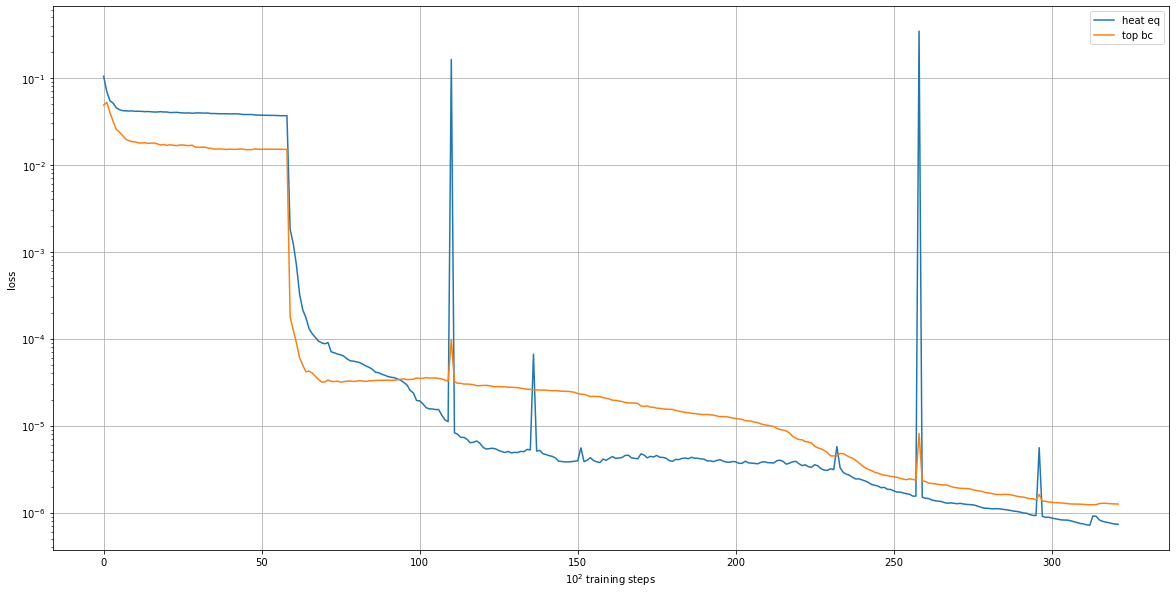

In [54]:
%matplotlib inline

n_1 = 2
n_2 = 100
plt.figure(figsize = (20, 10))

plt.plot(np.sum(losshistory.loss_train[n_1:], axis = 1), 'kx')
plt.yscale('log')
#plt.yticks()
plt.xlabel(r'$10^2$ training steps')
plt.ylabel('loss')
plt.grid()
plt.show()


loss_names = ['heat eq', 'top bc', 'side bc', 'ic']
n = 8
plt.figure(figsize = (20, 10))

for loss, name in zip(np.array(losshistory.loss_train).T, loss_names):
    plt.plot(loss[n_1:], label = name)

#plt.plot(np.sum(losshistory.loss_train, axis = 1), 'k-', label='combined loss')

plt.yscale('log')
plt.xlabel(r'$10^2$ training steps')
plt.ylabel('loss')
plt.grid()
plt.legend()

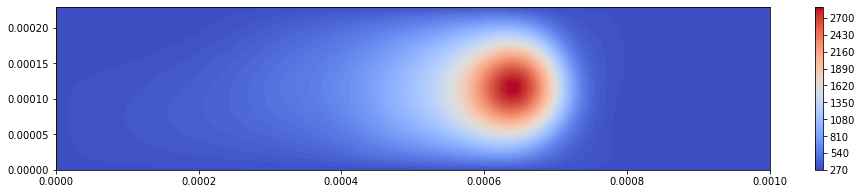

In [57]:
x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)
xx, yy, zz, pp, tt = np.meshgrid(x_lin, y_lin, [z_max], [120], [t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(pp), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
predict = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (16, 3))
plt.contourf(xi, yi, predict, 100, cmap=plt.cm.coolwarm)
plt.colorbar()

# XY, highest layer P = 250

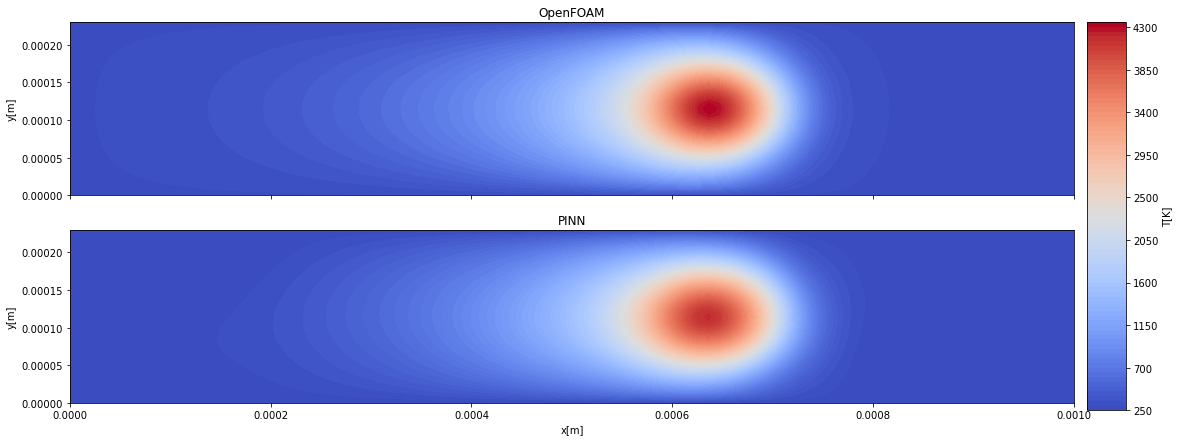

In [77]:
%matplotlib inline

i = 199
dt = t_max/200
end_data = np.genfromtxt('slices_no_phase/xy/slice_xy_dat_{}.csv'.format(i), delimiter = ',',skip_header = True)

x, y, z, T = end_data[:, 0], end_data[:, 1], end_data[:, 2], end_data[:, 3]

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')

X = np.vstack((x, y, np.ones(len(x))*z.max(),np.ones(len(x))*250,  np.ones(len(x))*dt*i)).T
Y = model.predict(X)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')
T_pred = griddata((x, y), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

#Plotting

fig, (ax1, ax2) = plt.subplots(ncols = 1, nrows = 2, figsize = (18, 7), sharex=True)

im = ax1.contourf(xi, yi, Ti, 100, cmap=plt.cm.coolwarm, vmin = T.min(), vmax = T.max())
CS = ax2.contourf(xi, yi, T_pred, 100, cmap=plt.cm.coolwarm, vmin = T.min(), vmax = T.max())

ax1.set_ylabel('y[m]')
ax1.set_title('OpenFOAM')
ax2.set_ylabel('y[m]')
ax2.set_xlabel('x[m]')
ax2.set_title('PINN')

cbar_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('T[K]')
plt.show()

# XY, highest layer P = 200

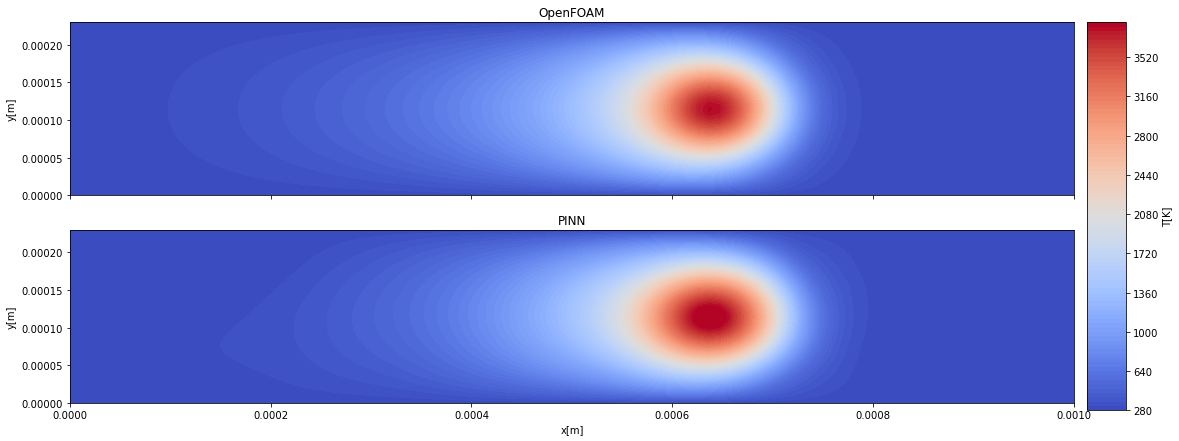

In [74]:
%matplotlib inline

i=199
dt = t_max/200
end_data = np.genfromtxt('200/domain_dat_{}.csv'.format(i), delimiter = ',',skip_header = True)

x, y, z, T = end_data[:, 0], end_data[:, 1], end_data[:, 2], end_data[:, 3]
mask = z == 1.00e-04

x, y, z, T = x[mask], y[mask], z[mask], T[mask]

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')

X = np.vstack((x, y, np.ones(len(x))*z.max(), np.ones(len(x))*220, np.ones(len(x))*dt*(i+1))).T
Y = model.predict(X)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')
T_pred = griddata((x, y), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

#Plotting

fig, (ax1, ax2) = plt.subplots(ncols = 1, nrows = 2, figsize = (18, 7), sharex=True)

im = ax1.contourf(xi, yi, Ti, 100, cmap=plt.cm.coolwarm, vmin = T.min(), vmax = T.max())
CS = ax2.contourf(xi, yi, T_pred, 100, cmap=plt.cm.coolwarm, vmin = T.min(), vmax = T.max())

ax1.set_ylabel('y[m]')
ax1.set_title('OpenFOAM')
ax2.set_ylabel('y[m]')
ax2.set_xlabel('x[m]')
ax2.set_title('PINN')

cbar_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('T[K]')
plt.show()